# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 6 - Bayesian Analysis



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 

**Students:**  Mark Carlebach amd Saurabh Kulkarni 

<hr style="height:2pt">

### Homework 6 is due April 10, 2019

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pyjags
import pandas as pd
import numpy as np
from scipy.special import expit

%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import os
os.environ['R_HOME'] = "/usr/share/anaconda3/lib/R"

from rpy2.robjects.packages import importr
r_utils = importr('utils')
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# Took some code from Mark's lecture notes to make this work
r_utils.install_packages('coda')
r_coda = importr('coda')

from collections import Counter

--- Please select a CRAN mirror for use in this session ---



Secure CRAN mirrors
 





 1: 0-Cloud [https]                   2: Algeria [https]                
 3: Australia (Canberra) [https]      4: Australia (Melbourne 1) [https]
 5: Australia (Melbourne 2) [https]   6: Australia (Perth) [https]      
 7: Austria [https]                   8: Belgium (Ghent) [https]        
 9: Brazil (PR) [https]              10: Brazil (RJ) [https]            
11: Brazil (SP 1) [https]            12: Brazil (SP 2) [https]          
13: Bulgaria [https]                 14: Chile 1 [https]                
15: Chile 2 [https]                  16: China (Hong Kong) [https]      
17: China (Guangzhou) [https]        18: China (Lanzhou) [https]        
19: China (Shanghai 1) [https]       20: China (Shanghai 2) [https]     
21: Colombia (Cali) [https]          22: Czech Republic [https]         
23: Denmark [https]                  24: East Asia [https]              
25: Ecuador (Cuenca) [https]      

/usr/share/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://mirrors.nics.utk.edu/cran/src/contrib/coda_0.19-2.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/share/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/share/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 73530 bytes (71 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/share/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/share/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/share/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 71 KB


  warnings.warn(x, RRuntimeWarning)
/usr/share/anaconda3/lib/

Note that this has been tested with 
* pandas version 0.22.0
* rpy2 version 2.9.4

The latest libraries may have changed somewhat since these versions; if you are having problems, try using these versions.


<hr style="height:2pt">

### Problem 1: President Donald Trump's Tweets

In the first part of this assignment, you will be working with text from the @realDonaldTrump Twitter account. This consists of all tweets from the account from 5/4/2009 to 2/26/2019. The goal is to use Latent Dirichlet Allocation in order to model the topics tweeted about since President Trump's inauguration.

The dataset is from http://www.trumptwitterarchive.com/archive.

Start by reading the dataset into a pandas data frame.

In [3]:
# Read in President Trump's tweet data
tweets = pd.read_csv("data/trump_tweets.csv")

Now, extract only the rows since President Trump's inauguration on January 20, 2017 (you can use midnight on that date as the start time). You should use the datetime.strptime to convert dates to type `datetime`. Hint: first, you should remove any rows with missing timestamps.

In [4]:
# Get rid of rows with null values in time column
tweets = tweets[tweets.created_at.notnull()]

# Add column with created time as datetime type
tweets["created_at_dt"] = pd.to_datetime(tweets.created_at)

# Filter for date >= midnight on innauguration
tweets = tweets[tweets.created_at_dt >= 
                datetime.strptime("1/20/17 00:00", "%m/%d/%y %H:%M")]

Preprocess the data by making it all lowercase. Remove a reasonable set of stopwords from the dataset and tokenize. Then, report the 50 most common words and their count. You may need to iterate this process, adding some stop words as you understand the structure of the data. Justify additional stop words you've added.


### First Pass at Creating Stop Words

In [5]:
# Convert text to lower case
tweets["text"] = tweets.text.str.lower()

# From Lab:  "words" in the corpus are any number of letters, digits, and apostrophes. 
# No hyphens or other fancyness.
tokenizer = RegexpTokenizer(r'[\w\']+') # \w means any letter or digit. 

# Create initial set of stopwords use default set
stop_words = set(stopwords.words('english'))

# Create a list of tweets (with each tweet purged of stop words)
purged_tweet_list = []
for tweet in tweets.text.values:
    tweet_word_list = tokenizer.tokenize(tweet)
    purged_word_list = [cur_word for cur_word in tweet_word_list if cur_word not in stop_words]
    purged_tweet_list.append(purged_word_list)
    
# Count most common words possibly to find additional stop words
counts = Counter([word for wordlist in purged_tweet_list for word in wordlist]) 
counts.most_common(50)

[('co', 2240),
 ('https', 2232),
 ('great', 1518),
 ('amp', 1152),
 ('rt', 1015),
 ('people', 789),
 ('president', 642),
 ('trump', 599),
 ('country', 568),
 ('news', 550),
 ('u', 512),
 ('fake', 495),
 ('big', 481),
 ('thank', 467),
 ('border', 467),
 ('democrats', 465),
 ('many', 464),
 ('today', 435),
 ('america', 416),
 ('get', 407),
 ('time', 394),
 ('new', 372),
 ('much', 338),
 ('would', 336),
 ('american', 335),
 ('realdonaldtrump', 328),
 ('good', 316),
 ('want', 316),
 ('years', 302),
 ('must', 302),
 ('never', 300),
 ('media', 295),
 ('security', 293),
 ('back', 287),
 ('vote', 284),
 ('wall', 283),
 ('one', 280),
 ('make', 278),
 ('jobs', 276),
 ('military', 272),
 ('united', 265),
 ('trade', 261),
 ('house', 260),
 ('states', 255),
 ('tax', 253),
 ('first', 251),
 ('job', 250),
 ('going', 247),
 ('election', 246),
 ('crime', 246)]

### Second Pass at Creating Stop Words

I am removing from the above list words that appear related to Twitter (e.g., "rt", "https") or are also very common (e.g., "would").

In [6]:
# Create initial set of stopwords based on my own knowledge of English language
stop_words.update(["co", "https", "amp", "rt", "u", "thank", "many", "get", "new", "much", "would", "good", "want", "must",
                   "never", "back", "me", "make", "first,", "time", "one", "first", "realdonaldtrump", "president", "trump"
                  ]
                 )

# Create a list of tweets (with each tweet purged of stop words)
purged_tweet_list = []
for tweet in tweets.text.values:
    tweet_word_list = tokenizer.tokenize(tweet)
    purged_word_list = [cur_word for cur_word in tweet_word_list if cur_word not in stop_words]
    purged_tweet_list.append(purged_word_list)
    
# Count most common words possibly to find additional stop words
counts = Counter([word for wordlist in purged_tweet_list for word in wordlist]) 
counts.most_common(50)

[('great', 1518),
 ('people', 789),
 ('country', 568),
 ('news', 550),
 ('fake', 495),
 ('big', 481),
 ('border', 467),
 ('democrats', 465),
 ('today', 435),
 ('america', 416),
 ('american', 335),
 ('years', 302),
 ('media', 295),
 ('security', 293),
 ('vote', 284),
 ('wall', 283),
 ('jobs', 276),
 ('military', 272),
 ('united', 265),
 ('trade', 261),
 ('house', 260),
 ('states', 255),
 ('tax', 253),
 ('job', 250),
 ('going', 247),
 ('election', 246),
 ('crime', 246),
 ('even', 245),
 ('state', 245),
 ('russia', 241),
 ('fbi', 238),
 ('done', 237),
 ('day', 234),
 ('working', 221),
 ('bad', 218),
 ('made', 217),
 ('like', 216),
 ('year', 209),
 ('strong', 208),
 ('korea', 208),
 ('collusion', 206),
 ('north', 205),
 ('dems', 204),
 ('us', 203),
 ('deal', 202),
 ('honor', 202),
 ('hard', 201),
 ('ever', 201),
 ('obama', 200),
 ('world', 193)]

### Final Pass at Creating Stop Words

I see a few more very common words to remove (e.g., "done", "going").

In [7]:
# Create initial set of stopwords based on my own knowledge of English language
stop_words.update(["going", "even", "made", "done", 
                  ]
                 )

# Create a list of tweets (with each tweet purged of stop words)
purged_tweet_list = []
for tweet in tweets.text.values:
    tweet_word_list = tokenizer.tokenize(tweet)
    purged_word_list = [cur_word for cur_word in tweet_word_list if cur_word not in stop_words]
    purged_tweet_list.append(purged_word_list)
    
# Count most common words possibly to find additional stop words
counts = Counter([word for wordlist in purged_tweet_list for word in wordlist]) 
counts.most_common(50)

[('great', 1518),
 ('people', 789),
 ('country', 568),
 ('news', 550),
 ('fake', 495),
 ('big', 481),
 ('border', 467),
 ('democrats', 465),
 ('today', 435),
 ('america', 416),
 ('american', 335),
 ('years', 302),
 ('media', 295),
 ('security', 293),
 ('vote', 284),
 ('wall', 283),
 ('jobs', 276),
 ('military', 272),
 ('united', 265),
 ('trade', 261),
 ('house', 260),
 ('states', 255),
 ('tax', 253),
 ('job', 250),
 ('election', 246),
 ('crime', 246),
 ('state', 245),
 ('russia', 241),
 ('fbi', 238),
 ('day', 234),
 ('working', 221),
 ('bad', 218),
 ('like', 216),
 ('year', 209),
 ('strong', 208),
 ('korea', 208),
 ('collusion', 206),
 ('north', 205),
 ('dems', 204),
 ('us', 203),
 ('deal', 202),
 ('honor', 202),
 ('hard', 201),
 ('ever', 201),
 ('obama', 200),
 ('world', 193),
 ('china', 192),
 ('whitehouse', 191),
 ('win', 187),
 ('way', 187)]

Find the optimal number of topics using the `u_mass` coherence measure. Plot the results; what does this plot suggest about the number of topics in the text?

In [8]:
# Convert text of tweets into Gensim Dictionary & corpus (leveraging lab examples)
masterdictionary = Dictionary(purged_tweet_list)
mastercorpus = [masterdictionary.doc2bow(tweet) for tweet in purged_tweet_list]

# Find optimal number of topics in all tweets via coherence measure u_mass (leveraging lab examples)
coherence_vals = []
for ntop in range(1,25):
    mod = LdaModel(mastercorpus, num_topics = ntop, id2word = masterdictionary, passes=10)
    cmod = CoherenceModel(model=mod, corpus=mastercorpus, dictionary=masterdictionary, coherence='u_mass')
    cval = cmod.get_coherence()
    print(ntop,cval)
    coherence_vals.append(cval)

1 -3.135837188036155
2 -3.277422554605473
3 -3.654411562939359
4 -3.431416270166305
5 -3.838901798881402
6 -3.8607562176095698
7 -4.918575608193454
8 -4.78344079032425
9 -5.111222948868451
10 -5.375080328954776
11 -6.784395428930664
12 -6.639505427117282
13 -6.366840687278797
14 -6.294649970619218
15 -6.449739960608746
16 -6.928923518236219
17 -7.098096728692817
18 -7.474396654821037
19 -7.496840091574258
20 -7.682062850636166
21 -7.565532462457575
22 -7.63840876942301
23 -7.880675842699894
24 -7.496782853729049


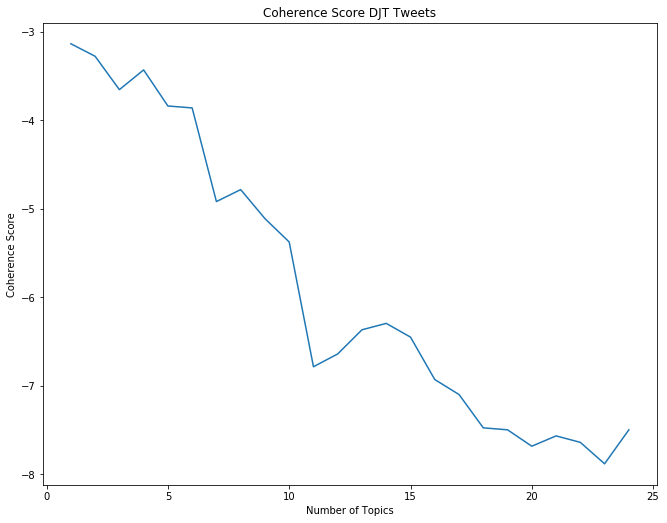

In [9]:
# Plotting as instructed in lab examples
plt.figure(figsize=(11,8.5))
plt.plot(range(1,25),coherence_vals)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score DJT Tweets");

4 appears to be the optimial number of topics.

Run LDA on the texts using the optimal value of $k$ found via your analysis above. Print out the top 10 words and associated betas for each of the $k$ topics. Comment on the results and their plausibility. What does each topic seem to represent?

In [10]:
# I am going to infer 4 is the best number of topics (though it varies by run)
# Create LDA with 4 topics, which seems "optimal" per chart above
mod = LdaModel(mastercorpus, num_topics = 4, id2word = masterdictionary, passes=10)

In [11]:
# Print top words and scores per topic
for i in range(4):
    for word, beta in mod.show_topic(i):
        print(f"Topic {i}:  word={word}, beta={beta}")
    print()

Topic 0:  word=great, beta=0.02252277545630932
Topic 0:  word=today, beta=0.012019908055663109
Topic 0:  word=whitehouse, beta=0.009141004644334316
Topic 0:  word=american, beta=0.006990288384258747
Topic 0:  word=honor, beta=0.006973445415496826
Topic 0:  word=day, beta=0.005943046882748604
Topic 0:  word=national, beta=0.004958535078912973
Topic 0:  word=job, beta=0.004643110558390617
Topic 0:  word=people, beta=0.004461925011128187
Topic 0:  word=house, beta=0.004259035456925631

Topic 1:  word=border, beta=0.011593129485845566
Topic 1:  word=democrats, beta=0.01145131979137659
Topic 1:  word=people, beta=0.01090292725712061
Topic 1:  word=news, beta=0.01025182195007801
Topic 1:  word=fake, beta=0.010087805800139904
Topic 1:  word=wall, beta=0.009286080487072468
Topic 1:  word=country, beta=0.008623383939266205
Topic 1:  word=big, beta=0.006800549104809761
Topic 1:  word=great, beta=0.0065660360269248486
Topic 1:  word=media, beta=0.006016731262207031

Topic 2:  word=southern, beta=

The topics seem very plausible:

- Topic 0 appears to be about the Russian colluion story stemming from election.
- Topic 1 appears to be about job growth and progress with economy.
- Topic 2 appears to be about  "fake" media.
- Topic 3 appears to be about border security and successful negotiations with NoKo.

### Problem 2: Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset-2-train.csv` and `dataset-2-test.csv` containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order.

In [12]:
# Read in the data
train = pd.read_csv("data/dataset_2_train.csv")
test = pd.read_csv("data/dataset_2_test.csv")

# Fix the problem for train
train["district"].replace(to_replace=61,
                          value=54,
                          inplace=True)
              
# Fix the problem for test
test["district"].replace(to_replace=61,
                         value=54,
                         inplace=True)

To verify the procedure, simulate binary response data assuming the following parameter values (and using the existing features and district information from the training data):

$\mu_{\beta_0} = 2$

$\sigma^2_{\beta_0} = 1$

$\beta_0 \sim N(\mu_{\beta_0},\sigma_{\beta_0}^2)$

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

In [13]:
# Define normal distribution parameters for beta0
mu_b0 = 2
var_b0 = 1 

# Define beta1, beta2, beta3
b1 = 4
b2 = -3
b3 = -2

# Create simulated beta0 variable (J of them)
J = len(train.district.unique())
b0_simulation = np.zeros(J)
for j in range(J):
    b0_simulation[j] = float(np.random.normal(loc=mu_b0,
                                              scale=var_b0**.5,
                                              size=1
                                             )
                            )

# Simulate response variable for each woman (using womans district as index for p)
N = train.shape[0]
simulated_response = np.zeros(N)
np.random.seed(109)
for i in range(N):
    
    # Create simulated response using Bernoulli (binomial with n-1) and p from woman's district    
    district = int(train.loc[i]["district"])
    urban = train.loc[i]["urban"]
    living_children = train.loc[i]["living.children"]
    age_mean = train.loc[i]["age_mean"]
    p = expit(b0_simulation[district-1] + b1*urban + b2*living_children + b3*age_mean)
    simulated_response[i] = np.random.binomial(n=1, p=p, size=1)
    
# Add results to train dataframe
train["simulated_response"] = simulated_response.astype(int)

Fit the varying-intercept model specified above to your simulated data.

In [14]:
contraception_code = '''
model {
    b1 ~ dnorm(0, 1/10000)
    b2 ~ dnorm(0, 1/10000)
    b3 ~ dnorm(0, 1/10000)
    
    mu0 ~ dnorm(0, 1/10000)
    prec0 ~ dgamma(.01, .01)
    
    for (j in 1:J) {
        b0[j] ~ dnorm(mu0, prec0)       
    }
    
    for (i in 1:N) {
        p[i,district[i]] = ilogit(b0[district[i]]+b1*urban[i] + b2*living_children[i] + b3*age_mean[i])  
    }
    
    for (i in 1:N) {        
        y[i] ~ dbern(p[i, district[i]])  
    }

}
'''

In [15]:
# Create variables for observed data
urban = train["urban"].values
living_children = train["living.children"].values
age_mean = train["age_mean"].values
district = train["district"].values
N = train.shape[0]
J = len(train.district.unique())

# Create variable for simulated response
y = train["simulated_response"]

# Set number of chains
n_chains = 4

# Define model as specified in the assignment
contraception_model = pyjags.Model(contraception_code, 
                                   data=dict(y=y,
                                             urban=urban, 
                                             living_children=living_children,
                                             age_mean=age_mean,
                                             district=district,
                                             J=J,
                                             N=N
                                            ),
                                   chains=n_chains
                                  )

adapting: iterations 1584 of 4000, elapsed 0:00:09, remaining 0:00:14
adapting: iterations 3404 of 4000, elapsed 0:00:18, remaining 0:00:03
adapting: iterations 4000 of 4000, elapsed 0:00:20, remaining 0:00:00


In [16]:
# Run the model
burnin = contraception_model.sample(1000)
samples = contraception_model.sample(3000)

sampling: iterations 1176 of 4000, elapsed 0:00:07, remaining 0:00:16
sampling: iterations 3000 of 4000, elapsed 0:00:16, remaining 0:00:05
sampling: iterations 4000 of 4000, elapsed 0:00:21, remaining 0:00:00
sampling: iterations 2244 of 12000, elapsed 0:00:10, remaining 0:00:43
sampling: iterations 4548 of 12000, elapsed 0:00:20, remaining 0:00:33
sampling: iterations 6844 of 12000, elapsed 0:00:29, remaining 0:00:22
sampling: iterations 9180 of 12000, elapsed 0:00:41, remaining 0:00:13
sampling: iterations 11420 of 12000, elapsed 0:00:50, remaining 0:00:03
sampling: iterations 12000 of 12000, elapsed 0:00:53, remaining 0:00:00


Plot the trace plots of the MCMC sampler for the parameters $\mu_{\beta_0}, \sigma_{\beta_0}, \beta_1, \beta_2, \beta_3$. Does it look like the samplers converged?

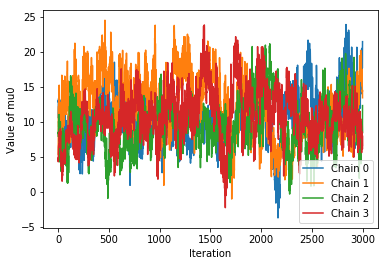

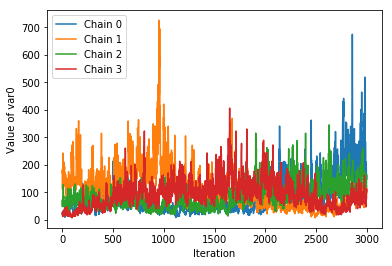

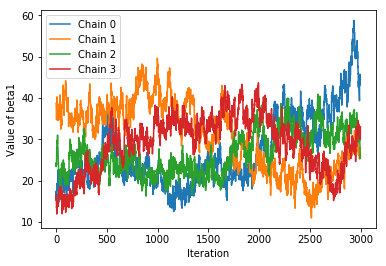

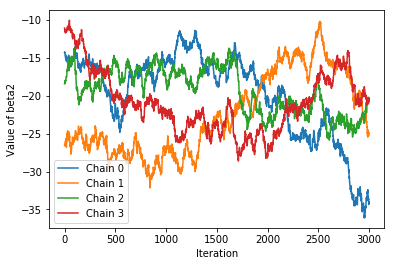

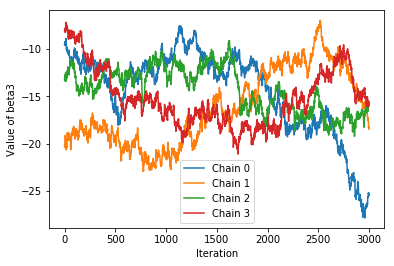

In [17]:
def plot_trace(samples, varname, entry=0):
    """This code is stolen from Will's lab"""
    
    plt.plot()
    sample_array = samples[varname]

    vec_len, num_samples, num_chains = sample_array.shape
    for cur_chain in range(num_chains):
        cur_label = "Chain {}".format(cur_chain)
        plt.plot(range(num_samples),sample_array[entry,:,cur_chain], label=cur_label)
    plt.legend()
    plt.show()

# Trace plot for mu0 (re-using code from lab)
plt.xlabel("Iteration")
plt.ylabel("Value of mu0")
plot_trace(samples,'mu0')

# Trace plot for var0 (re-using code from lab)
# Create new entry in samples with 1/precision to plot variance
samples["var0"] = 1/samples.get("prec0")
plt.xlabel("Iteration")
plt.ylabel("Value of var0")
plot_trace(samples,'var0')

# Trace plot for beta1 (re-using code from lab)
plt.xlabel("Iteration")
plt.ylabel("Value of beta1")
plot_trace(samples,'b1')

# Trace plot for beta2 (re-using code from lab)
plt.xlabel("Iteration")
plt.ylabel("Value of beta2")
plot_trace(samples,'b2')

# Trace plot for beta3 (re-using code from lab)
plt.xlabel("Iteration")
plt.ylabel("Value of beta3")
plot_trace(samples,'b3')

It does **not** look as though the samplers converged.  But, we will proceed anyway.

Plot histograms of the posterior distributions for the parameters $\beta_{0,10}$, $\beta_{0,20}$,...,$\beta_{0,60}$. Are the actual parameters that you generated contained within these posterior distributions? 

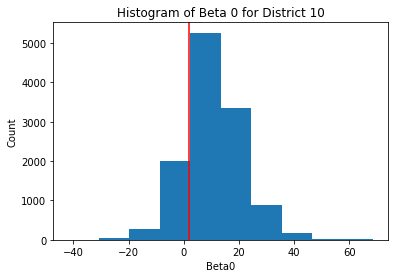

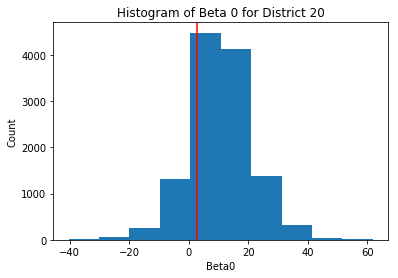

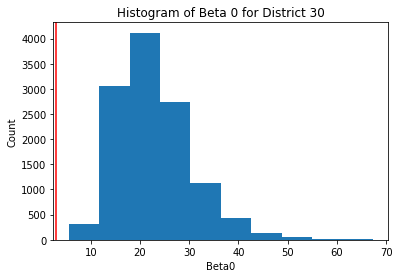

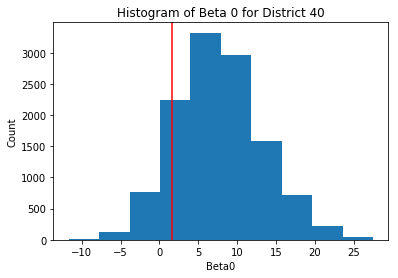

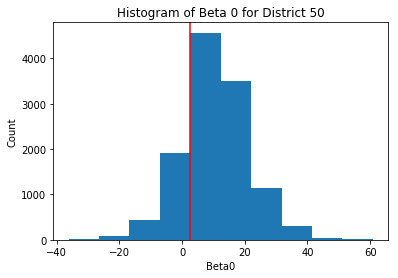

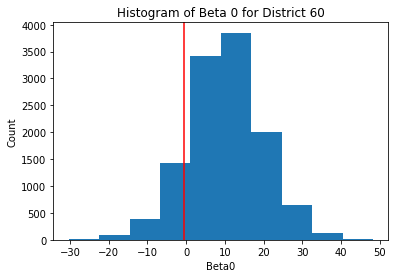

In [18]:
# Grab data from pyjags with b0 data
b0_sample_array = samples["b0"]

# For each district
for j in range(9, 60, 10):
    
    # Get the data from all the chains
    data_from_chains = [b0_sample_array[j,:,chain_num] for chain_num in range(n_chains)]    
    x = np.concatenate(data_from_chains)
    
    # Plot histogram of betas generated and red line of simulated beta0
    plt.hist(x)
    plt.title(f"Histogram of Beta 0 for District {j+1}")
    plt.xlabel(f"Beta0")
    plt.ylabel("Count")
    plt.axvline(x=b0_simulation[j], color="r")
    plt.show()

The beta0 generated in the simulation (shown by red lines above) do (for the most part) fit within the histograms of the beta0 values generated by pyjags.

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [19]:
# Create variable for actual response
y = train["contraceptive_use"]

# Make sure model binds with new y values
contraception_model = pyjags.Model(contraception_code, 
                                   data=dict(y=y,
                                             urban=urban, 
                                             living_children=living_children,
                                             age_mean=age_mean,
                                             district=district,
                                             J=J,
                                             N=N
                                            ),
                                   chains=n_chains
                                  )

# Run the model
burnin = contraception_model.sample(1000)
samples = contraception_model.sample(3000)

adapting: iterations 1384 of 4000, elapsed 0:00:05, remaining 0:00:10
adapting: iterations 4000 of 4000, elapsed 0:00:15, remaining 0:00:00
adapting: iterations 4000 of 4000, elapsed 0:00:15, remaining 0:00:00
sampling: iterations 1244 of 4000, elapsed 0:00:05, remaining 0:00:12
sampling: iterations 2380 of 4000, elapsed 0:00:11, remaining 0:00:07
sampling: iterations 4000 of 4000, elapsed 0:00:17, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:17, remaining 0:00:00
sampling: iterations 1100 of 12000, elapsed 0:00:05, remaining 0:00:50
sampling: iterations 2180 of 12000, elapsed 0:00:10, remaining 0:00:46
sampling: iterations 4340 of 12000, elapsed 0:00:20, remaining 0:00:36
sampling: iterations 6484 of 12000, elapsed 0:00:30, remaining 0:00:25
sampling: iterations 8668 of 12000, elapsed 0:00:41, remaining 0:00:16
sampling: iterations 10792 of 12000, elapsed 0:00:50, remaining 0:00:06
sampling: iterations 12000 of 12000, elapsed 0:00:56, remaining 0:00:00
sampling: i

Check the convergence by examining the trace plots, as you did with the simulated data. What do you observe?

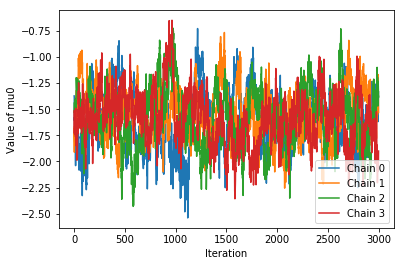

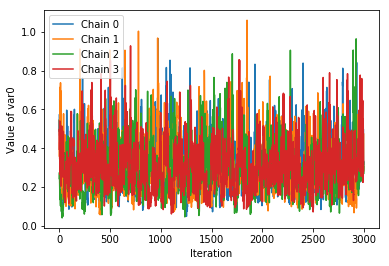

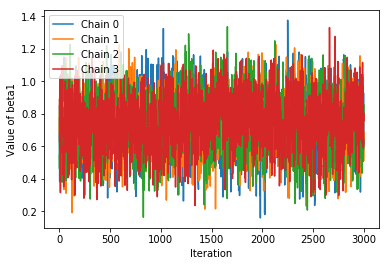

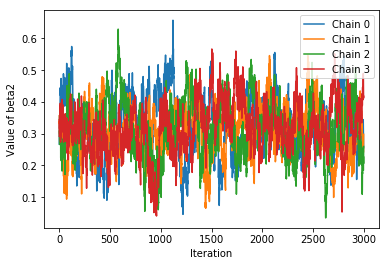

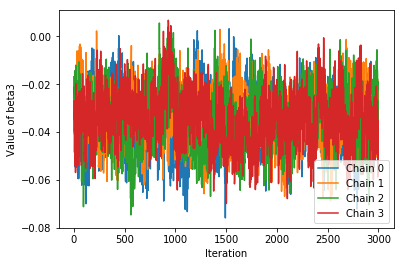

In [20]:
# Trace plot for mu0 (re-using code from lab)
plt.xlabel("Iteration")
plt.ylabel("Value of mu0")
plot_trace(samples,'mu0')

# Trace plot for prec0 (re-using code from lab)
# Create new entry in samples with 1/precision to plot variance
samples["var0"] = 1/samples.get("prec0")
plt.xlabel("Iteration")
plt.ylabel("Value of var0")
plot_trace(samples,'var0')

# Trace plot for beta1 (re-using code from lab)
plt.xlabel("Iteration")
plt.ylabel("Value of beta1")
plot_trace(samples,'b1')

# Trace plot for beta2 (re-using code from lab)
plt.xlabel("Iteration")
plt.ylabel("Value of beta2")
plot_trace(samples,'b2')

# Trace plot for beta3 (re-using code from lab)
plt.xlabel("Iteration")
plt.ylabel("Value of beta3")
plot_trace(samples,'b3')

This time the sampler seemed to come closer to convergence (though not fully there), with fewer patterns visible in the trace plots when compared to the previous model--especially for beta1.

Based on the posterior means, women belonging to which district are most likely to use contraceptives? Women belonging to which district are least likely to use contraceptives?

In [21]:
# Initialize mean and variance of b0s from pyjags
mean_b0_pyjags = np.zeros(J)
var_b0_pyjags = np.zeros(J)

# Grab data from pyjags with b0 data, concatenate and take mean and variance of samples
b0_sample_array = samples["b0"]
for j in range(J):
    data_from_chains = [b0_sample_array[j,:,chain_num] for chain_num in range(n_chains)]
    mean_b0_pyjags[j] = np.concatenate(data_from_chains).mean()
    var_b0_pyjags[j] = np.concatenate(data_from_chains).var()

# I am assuming you are asking for the district with the lowest and  highest intercept
print(f"Based on means of posteior samples of b0s, District {np.argmin(mean_b0_pyjags)} is least likely to use contraceptives.")
print(f"Based on means of posteior samples of b0s, District {np.argmax(mean_b0_pyjags)} is most likely to use contraceptives.")

Based on means of posteior samples of b0s, District 10 is least likely to use contraceptives.
Based on means of posteior samples of b0s, District 55 is most likely to use contraceptives.


We are assuming the question is asking us to look at the mean of posterior samples for each District's beta0 (i.e., interecept) and infer that the District with the lowest intercept has the lowest base rate of contrceptive use...and the District with the highest intercept has the highest base rate of contraception.  (In contrast, we do not think you are asking us to use the betas to predict y-hats different from the observed ys in the training data just so we could try to estimate which District uses contraception the least/most.)

With the above assumption, here are the answers:

- District 10 is least likely to use contraception.
- District 55 is most likely to use contraception.

What are the posterior means of $\mu_{\beta_0}$ and $\sigma^2_{\beta_0}$? Do these values offer any evidence in support of or against the varying-intercept model?

In [22]:
# Print means and variances for b0 for each district
for j in range(J):
    print(f"District {j} b0 mean = {mean_b0_pyjags[j]} and b0 var = {var_b0_pyjags[j]}.")

District 0 b0 mean = -2.105258734263167 and b0 var = 0.1497624662706387.
District 1 b0 mean = -1.758146957906039 and b0 var = 0.24159671525137758.
District 2 b0 mean = -1.476686182996129 and b0 var = 0.3460356298174332.
District 3 b0 mean = -1.4176894290677968 and b0 var = 0.22269582815388458.
District 4 b0 mean = -1.580787018892188 and b0 var = 0.2207703847837731.
District 5 b0 mean = -1.951272781726475 and b0 var = 0.16817593869454478.
District 6 b0 mean = -1.9939170590048179 and b0 var = 0.2514728259920633.
District 7 b0 mean = -1.3650755985530665 and b0 var = 0.1946207128726713.
District 8 b0 mean = -2.045415781867264 and b0 var = 0.28437224792059734.
District 9 b0 mean = -2.0841026171818577 and b0 var = 0.30454011619308397.
District 10 b0 mean = -2.1577584834856642 and b0 var = 0.29005384248839194.
District 11 b0 mean = -1.6362004627621802 and b0 var = 0.21056242238304057.
District 12 b0 mean = -1.4902129690491663 and b0 var = 0.20404534113219489.
District 13 b0 mean = -1.28142464

To the extent we can trust the pyjags models despite the lack of convergence in the trace plots, the means and variances suggest the distributions for the different b0s meaningfully overlap.  This is evidence **against** a varying intercept model.

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?

In [23]:
contraception_code = '''
model {    
    mu0 ~ dnorm(0, 1/10000)
    prec0 ~ dgamma(.01, .01)
    prec1 ~ dgamma(.01, .01)
    prec2 ~ dgamma(.01, .01)
    prec3 ~ dgamma(.01, .01)
    
    for (j in 1:J) {
        b0[j] ~ dnorm(mu0, prec0)    
        b1[j] ~ dnorm(0, prec1)
        b2[j] ~ dnorm(0, prec2)
        b3[j] ~ dnorm(0, prec3)
    }
    
    for (i in 1:N) {
        p[i,district[i]] = ilogit(b0[district[i]] + 
                                  b1[district[i]]*urban[i] + 
                                  b2[district[i]]*living_children[i] + 
                                  b3[district[i]]*age_mean[i]
                                  )  
    }
    
    for (i in 1:N) {        
        y[i] ~ dbern(p[i, district[i]])  
    }

}
'''

In [24]:
# Define model as specified in the assignment
contraception_model = pyjags.Model(contraception_code, 
                                   data=dict(y=y,
                                             urban=urban, 
                                             living_children=living_children,
                                             age_mean=age_mean,
                                             district=district,
                                             J=J,
                                             N=N
                                            ),
                                   chains=n_chains
                                  )

adapting: iterations 2436 of 4000, elapsed 0:00:05, remaining 0:00:04
adapting: iterations 4000 of 4000, elapsed 0:00:09, remaining 0:00:00


In [25]:
# Run the model
burnin = contraception_model.sample(1000)
samples = contraception_model.sample(3000)

sampling: iterations 3376 of 4000, elapsed 0:00:10, remaining 0:00:02
sampling: iterations 4000 of 4000, elapsed 0:00:12, remaining 0:00:00
sampling: iterations 1656 of 12000, elapsed 0:00:05, remaining 0:00:31
sampling: iterations 4952 of 12000, elapsed 0:00:15, remaining 0:00:22
sampling: iterations 8228 of 12000, elapsed 0:00:26, remaining 0:00:12
sampling: iterations 11420 of 12000, elapsed 0:00:35, remaining 0:00:02
sampling: iterations 12000 of 12000, elapsed 0:00:36, remaining 0:00:00


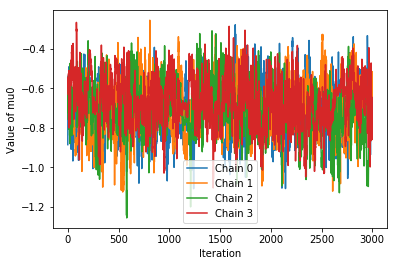

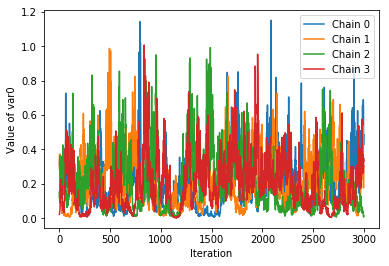

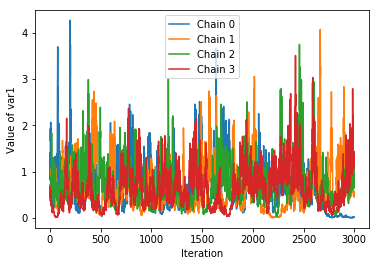

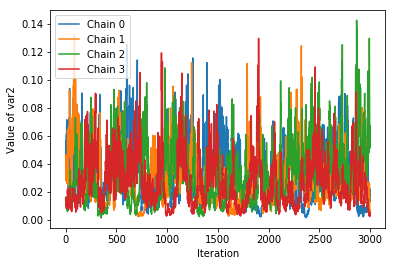

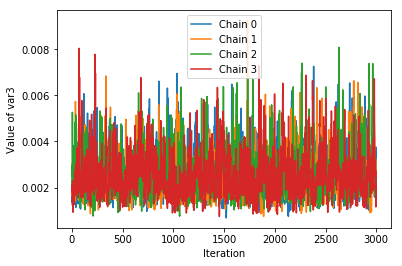

In [26]:
# Out of curiosity:  trace plot for mu0
plt.xlabel("Iteration")
plt.ylabel("Value of mu0")
plot_trace(samples,'mu0')

# OOC:  trace plot for var0
# Create new entry in samples with 1/precision to plot variance
samples["var0"] = 1/samples.get("prec0")
plt.xlabel("Iteration")
plt.ylabel("Value of var0")
plot_trace(samples,'var0')

# OOC:  trace plot for var1
# Create new entry in samples with 1/precision to plot variance
samples["var1"] = 1/samples.get("prec1")
plt.xlabel("Iteration")
plt.ylabel("Value of var1")
plot_trace(samples,'var1')

# OOC:  trace plot for var2
# Create new entry in samples with 1/precision to plot variance
samples["var2"] = 1/samples.get("prec2")
plt.xlabel("Iteration")
plt.ylabel("Value of var2")
plot_trace(samples,'var2')

# OOC:  trace plot for var3
# Create new entry in samples with 1/precision to plot variance
samples["var3"] = 1/samples.get("prec3")
plt.xlabel("Iteration")
plt.ylabel("Value of var3")
plot_trace(samples,'var3')

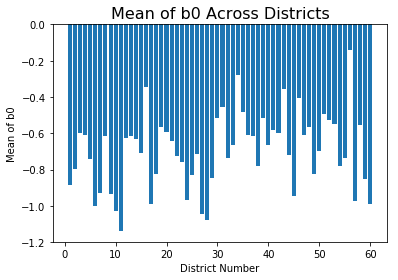

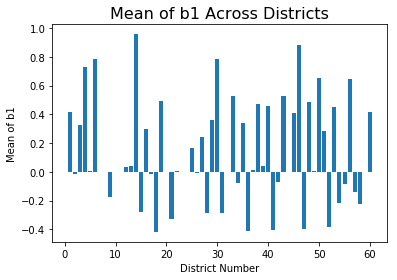

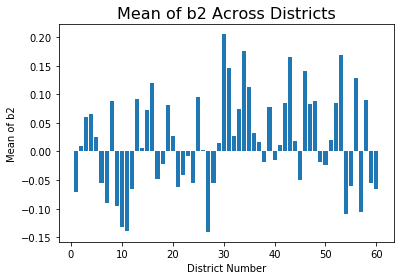

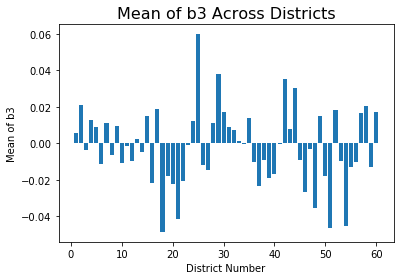

In [27]:
# Initialize array to store 60 means for 4 coefficients (b0, b1, b2, b3)
coeff_means = np.zeros((4,J))
    
# For coefficient and each district
for i, coef in enumerate(["b0", "b1", "b2", "b3"]):
    
    for j in range(J):
    
        # Grab data from pyjags for coefficient of interest
        sample_array = samples[coef]
        
        # Get the data from all the chains
        data_from_chains = [sample_array[j,:,chain_num] for chain_num in range(n_chains)]

        # Calculate the means for each beta
        coeff_means[i,j] = np.concatenate(data_from_chains).mean()

    # Barplot of means across districts for this coefficient
    plt.bar(range(1,J+1), coeff_means[i,:])
    plt.title(f"Mean of {coef} Across Districts", fontsize=16)
    plt.xlabel(f"District Number")
    plt.ylabel(f"Mean of {coef}")
    plt.show()

It seems as though Beta1 is the coefficient with the widest swing and most variation, suggesting a Beta1 that varies by district is good to have in the model.

Beta3 is the Beta that seems the most similar regardless of district, suggesting a Beta3 could/should be common across all districts

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

In [28]:
# Get number of rows in test set
N = test.shape[0]

# Create array for predictions on test data with learned Betas from earlier pyjags work
predictions = np.zeros(N)

# Needed to ensure repeatability of the bernoulli draw below
np.random.seed(109)

# Make predictions on test data using estimates of beta coefficients for each district
# That is, the best estimates for beta are the means of the posterior samples obtained from the training data
for row in test.itertuples():
    district = row.district
    p = expit(coeff_means[0, district-1] +
              coeff_means[1, district-1] * row.urban +
              coeff_means[2, district-1] * row._3 +
              coeff_means[3, district-1] * row.age_mean
             )
    predictions[row.Index] = np.random.binomial(n=1, p=p, size=1)

# Calculdate accuracy
accuracy = accuracy_score(predictions, test.contraceptive_use)

# Report accuracy
print(f"Classification accuracy on test set = {accuracy}")

Classification accuracy on test set = 0.5491209927611168


The mean of the sample posteriors for each coefficient **is** the best estimate we have for each coefficient.  (Or we could use median as an alternative.) 

Therefore, we used these estimated betas with the test data to make predictions and measure accuracy above.

The model produced an unimpressive accuracy score of .549